# Graphlet Plot Object
This class and demo script create a multi-part time-series graph containing a combination of categorical and continuous variables on its y-axis.  The code in the cell with comment 'graphlet_plot.py' is also in that file in the libs sub-directory.  The following use cases are enabled by this code:
* plotting a categorical y-column versus datetime
* plotting several 'flag' columns --each in its own y-axis 'channel.'  The function, CreateCombinedFlagColSeries, combines these columns into a single x and y data series
* plotting an unscaled, continuous y variable versus time
* plotting a scaled, continuous y variable versus time.  This is useful in the case of a multi-part plot that contains multiple continuous y variables.  The y-axis can be in units of one of the variables.  The others must be scaled to the same units

J.D. Landgrebe 8/7/20

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

#Import JDL utility modules
import sys
sys.path.append(sys.path[0] + '/libs/')
import pd_util
import util
import graphlet_plot

In [2]:
#graphlet_plot.py
class Graphlet():
    """
    Set attributes common to Categorical and Continuous plots. Parent of
    GraphletCategorical and GraphletContinuous
    
    Attributes:
    t_range [tuple - datetime format] - the datetime range of plot data
    ylims [tuple - either numeric or None] - (ymin, ymax) for the Graphlet 
           in y-axis units.  Specify either ymin or ymax to anchor Graphlet
           location on y-axis of plot
    spacing [tuple - numeric] - (spacing between categories, buffer between
                                graphlets)
    data [tuple - Pandas Series] (x-data, unscaled/unmapped y-data)
    IsHLine [boolean] toggles horizontal line below the graphlet on the plot
    heading - [string] - optional heading to label graphlet at its top left
    dot_format [tuple - mixed types] - (string Matplotlib color, integer dot
                size, integer dot transparency)
                      
    Version: 8/6/20 JDL Data Delve LLC
    """
    def __init__(self, t_range, spacing, ylims, data, IsHLine, heading=None, dot_format=None):
        self.xdata = data[0]
        self.ydata_unscaled = data[1]
        self.heading = ''
        if not heading is None: self.heading = heading
        if not dot_format[0] is None: self.dotcolor = dot_format[0]
        if not dot_format[1] is None: self.dotsize = dot_format[1]
        if not dot_format[2] is None: self.dot_transparency = dot_format[2]
        
        self.heading_coords = (t_range[0], (self.ymax + 1 * spacing[1])) #Label's x-y position
        self.hline = None
        self.ypos_hline = None
        if IsHLine: self.ypos_hline = self.ymin - spacing[1]
            
class GraphletCategorical():
    """
    Set attributes for categorical time-series plots. Map y-values to 
    specified categories

    Child of Graphlet, which initializes common attributes between
    GraphletCategorical and GraphletContinuous
    
    Attributes:
    See Parent Class docstring for its attributes
    
    ticklabels - dictionary of categorical keys (in terms of unmapped y-data)
                  and values that are labels to use on the plot for data series
    Methods:
    CreateCombinedFlagColSeries
    CalculateYLimitsCategorical
    SeriesFromDFCols
    
    Version: 8/7/20 JDL Data Delve LLC
    """
    def __init__(self, t_range, spacing, ylims, data, IsHLine, ticklabels=None, heading=None, dot_format=None):
        
        #Generate y-limits, ticklist and labels for categorical plot
        lst_cats = list(set(data[1]))
        ncats = len(lst_cats)
        self.ymin, self.ymax = GraphletCategorical.CalculateYLimitsCategorical(ylims, ncats, spacing)

        Graphlet.__init__(self, t_range, spacing, ylims, data, IsHLine, heading, dot_format)

        self.ticklist, self.labels = [], []
        for i, cat in zip(range(0,ncats), lst_cats):
            self.ticklist.append(self.ymin+ (i * spacing[0]))
            if ticklabels is not None:
                self.labels.append(ticklabels[cat])
            else:
                self.labels.append(cat)
                
        #Generate y-data that maps categories to ticklist values
        self.ydata = pd_util.MapSerToAltVals(self.ydata_unscaled, lst_cats, self.ticklist)

    def CreateCombinedFlagColSeries(lst_flags):
        """
        Create Concatenated Series with mapped flag values and create dictionary of original 
        flag column names or labels by value.

        Designed to work on columns that use 1/blank to flag time series discrete 
        events. This function maps multiple such columns to alternate integers and 
        concatenates the result into a single series.  The returned dictionary decodes
        how integers and original column names (or integers and user-specified labels)
        match up.

        Args:
        lst_flags (list of 3-item or, optionally, 4-item tuples) describing one or more
                    series to be concatenated:
                    df name - name of Pandas DataFrame containing valuecol and indexcol 
                    valuecol - column in df to serve as returned series values
                    indexcol - column in df to serve as returned series index
                    label string [optional] - Description for plot labeling

        Returns:
        Concatenated Series with original values mapped to integers
        Dictionary of integer (keys) to original column names (values)
        """

        lst_flag_series, ticklabels = [], {}
        for flag, i in zip(lst_flags, range(0,len(lst_flags))):

            #Default to None label then check whether it's specified
            label = None
            if len(flag) == 3: (df, valuecol, indexcol) = flag
            if len(flag) == 4: (df, valuecol, indexcol, label) = flag

            #Create a series from flag and append it to list of such series
            ser = pd_util.SeriesFromDFCols(df, valuecol, indexcol, 'int64')
            ser = pd_util.MapSerToAltVals(ser, [1], [i+1])
            lst_flag_series.append(ser)

            #Add a label to dict --either column name or user-specified string
            ticklabels[i+1] = ser.name
            if not label is None: ticklabels[i+1] = label
        return pd.concat(lst_flag_series), ticklabels

    def CalculateYLimitsCategorical(ylims, ncats, spacing):
        """
        Populate y-limits for Categorical plots from either upper or lower limit

        Args:
        ylims [tuple; number] - (lower, upper) y-limits; one may be None
        ncats [integer] - number of categories
        spacing [tuple; number] - (spacing between categories, spacing between graphlets) in y-axis limits

        Returns:
        individual ymin and ymax (calculation overrides specified values if ylims input has both specified)
        """
        if ylims[0] is not None:
            ymin = ylims[0]
            ymax = ymin + (ncats - 1) * spacing[0]
        elif ylims[1] is not None:
            ymax = ylims[1]
            ymin = ymax - (ncats - 1) * spacing[0]
        else:
            return None, None
        return ymin, ymax

    def SeriesFromDFCols(df, valcol, indexcol, dtype=None):
        """
        Convert two DataFrame columns into a Series as index and values

        args:
        df (Pandas DataFrame) - DataFrame containing valcol and indexcol
        valcol (String) - name of DataFrame column to return as Series values (and name of Series)
        indexcol (String) - name of DataFrame column to return as Series index
        dtype (Python dtype - typically int) - optional returned dtype of Series
        """
        ser = pd.Series(df[valcol].values, index=df[indexcol]).dropna()
        ser.name = valcol
        if not dtype is None: ser = ser.astype(dtype)
        return ser

class GraphletContinuous():
    """
    Set attributes for continuous variable graphlet
    Optionally, rescale y-values for graphing
    
    Child of Graphlet, which initializes common attributes between
    GraphletCategorical and GraphletContinuous
    
    Attributes:
    See Parent Class docstring for its attributes
    
    ticklabels - Optional dictionary of values (unscaled y units) as keys 
                      string labels as values
    scale_orig - [tuple - numeric]: Upper and lower values in unscaled y-units
                 for linear rescaling to plot y-axis units)
    scale_scaled [tuple - numeric]: Upper and lower values in scaled y-units;
                 used with scale_orig for linear rescaling of y-data
                      
    Methods: None

    Version: 8/6/20 JDL Data Delve LLC
    """
    def __init__(self, t_range, spacing, ylims, data, IsHLine, ticklabels=None, heading=None, scale_orig=None, scale_scaled=None, dot_format=None):
        
        self.ymin = ylims[0]
        self.ymax = ylims[1]
        Graphlet.__init__(self, t_range, spacing, ylims, data, IsHLine, heading, dot_format)

        IsScaled = False
        if (scale_orig is not None) and (scale_scaled is not None): IsScaled=True
            
        #If specified, scale the y-values and the ticklist values
        self.ydata = self.ydata_unscaled
        if IsScaled: 
            self.ydata = pd_util.RescaleSerValues(self.ydata_unscaled, scale_orig, scale_scaled)
            
        #Build ticklist and tick label list
        if not ticklabels is None:
            self.ticklist, self.labels = [], []
            for k, v in ticklabels.items():
                
                #Scale the tick value if needed
                k_scaled = k
                if IsScaled: k_scaled = pd_util.RescaleValue(k, scale_orig, scale_scaled)
                
                #Add tick and label to lists; If no specified label, tick value is the label
                self.ticklist.append(k_scaled)
                if v is not None: 
                    self.labels.append(v)
                else:
                    self.labels.append(k_scaled)

In [3]:
from matplotlib.dates import MonthLocator, DayLocator, DateFormatter
import matplotlib.ticker as mticker

def FormatTimeSeriesGraphletPlot(axes, t_range, y_range, ticks, labels, plottitle, x_strftime_format, sizes):
    """Apply custom formatting to the graphlet plot"""
    axes.set(xlim=t_range)
    axes.set_ylabel('')
    axes.set_xlabel('')
    axes.yaxis.set_major_locator(mticker.FixedLocator(ticks))

    axes.xaxis.set_major_locator(DayLocator())
    axes.xaxis.set_major_formatter(DateFormatter(x_strftime_format))
    axes.set_yticklabels(labels, fontsize=sizes[0]);
    axes.set_title(plottitle, fontsize=sizes[2])
    axes.set_yticklabels(labels)
    axes.tick_params(axis='x', labelsize=sizes[1])
    axes.tick_params(axis='y', labelsize=sizes[0])
    return axes

def UpdateYRange(cls, y_range):
    """Upadte tuple (min, max) based on Class instance min and max"""
    ymin, ymax = y_range
    if ymin is None: ymin = cls.ymin
    if ymax is None: ymax = cls.ymax
    if cls.ymin < ymin: ymin = cls.ymin
    if cls.ymax > ymax: ymax = cls.ymax
    return (ymin, ymax)

In [4]:
#Initialize DataFrame with sample data and label dictionary
datetime_col, flag1_col, flag2_col, cats_col, cont_col = 'datetime', 'On_flag', 'Off_flag', 'cats', 'continuous'
lst_dates, lst_flag1, lst_flag2 = ['1/1/2020', '1/2/2020', '1/3/2020', '1/4/2020'], [1, np.nan, 1, np.nan], [np.nan, 1, np.nan, 1]
lst_cat_var = ['A','B','A','C']
lst_cont_var = [10, 50, 75, 90]

df = pd.DataFrame({datetime_col:lst_dates, flag1_col:lst_flag1, flag2_col:lst_flag2, cats_col:lst_cat_var, cont_col:lst_cont_var})
df[datetime_col] = pd.to_datetime(df[datetime_col])
df

,datetime,On_flag,Off_flag,cats,continuous
0,2020-01-01,1.0,NaN,A,10
1,2020-01-02,NaN,1.0,B,50
2,2020-01-03,1.0,NaN,A,75
3,2020-01-04,NaN,1.0,C,90


## Configure and create a custom, graphlet-based plot

In [5]:
#Non-Data-Dependent Configuration - correspondence across dictionaries
spacing = (10, 5) #(category spacing, y-buffer) in y-axis units
t_range = (df[datetime_col].min() - timedelta(days=1),df[datetime_col].max() + timedelta(days=1))

#Dictionaries contain configuration of each graphlet
GraphletIsCategorical = {'cats1':True, 'cats2':True, 'cont1':False, 'cont2':False}

dot_formats = {'cats1':('xkcd:magenta',50,0.75), 'cats2':('xkcd:ocean',50,0.75), 'cont1':('xkcd:black',100,1.0), 'cont2':('xkcd:bright orange',100,1.0)}

headings = {'cats1':'Categories', 'cats2':'Multiple Flag Columns', 'cont1':'Continuous y variable', 'cont2':'Rescaled Continuous y'}

ylims = {'cats1':(100 + (2 * spacing[1]), None), 'cats2':(None, 0 - (2 * spacing[1])), 'cont1':(0, 100), 'cont2':(-125, -30)}

scale_orig = {'cats1':None, 'cats2':None, 'cont1':None, 'cont2':(0,100)}

scale_scaled = {'cats1':None, 'cats2':None, 'cont1':None, 'cont2':(-125,-25)}

hline = {'cats1':True, 'cats2':True, 'cont1':True, 'cont2':False}

#### data-dependent configuration and plotting - can loop on this cell to create multiple plots for various datasets

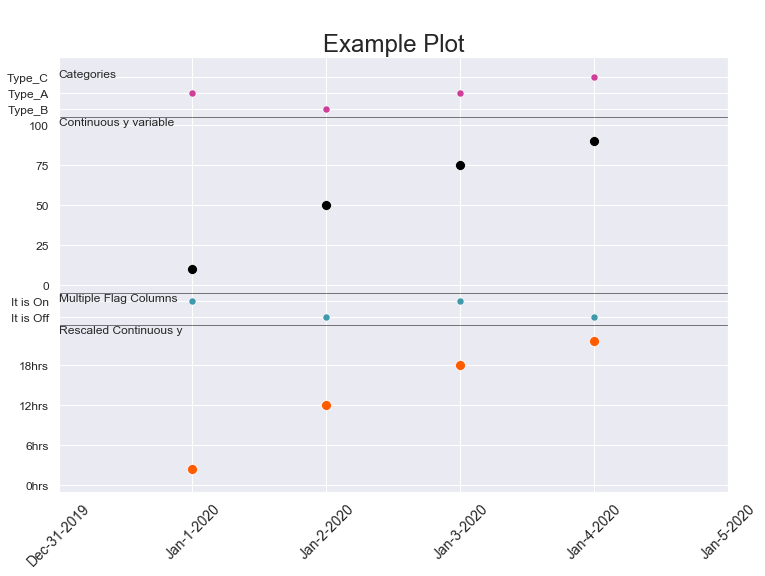

In [6]:
cats2_lst_flags = [(df, flag2_col, datetime_col, 'It is Off'), (df, flag1_col, datetime_col, 'It is On')]
cats2_ser, cats2_ticklabels = GraphletCategorical.CreateCombinedFlagColSeries(cats2_lst_flags)

cont1_ticklabels = {}
for i in range(0,125,25): cont1_ticklabels[i] = i

data = {'cats1':(df[datetime_col], df[cats_col]), 'cats2':(pd.Series(cats2_ser.index.values), pd.Series(cats2_ser.values)),
         'cont1':(df[datetime_col], df[cont_col]), 'cont2':(df[datetime_col], df[cont_col])}

ticklabels = {'cats1':dict(zip(sorted(set(df[cats_col].unique())), ['Type_A', 'Type_B', 'Type_C'])),
              'cats2':cats2_ticklabels, 'cont1':dict(zip([0,25,50,75,100], [0,25,50,75,100])),
              'cont2':dict(zip([0, 25, 50, 75],['0hrs','6hrs','12hrs','18hrs']))}

#Create a multi-part vertical plot with four graphlets
sns.set()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
plt.xticks(rotation=45)

#First, build a list of graphlet class instances with each of their data and settings
lst = []
for g in ['cats1', 'cats2', 'cont1', 'cont2']:
    if GraphletIsCategorical[g]: 
        lst.append(GraphletCategorical(t_range, spacing, ylims[g], data[g], hline[g], ticklabels[g], headings[g], dot_formats[g]))
    if not GraphletIsCategorical[g]: 
        lst.append(GraphletContinuous(t_range, spacing, ylims[g], data[g], hline[g], ticklabels[g], headings[g], scale_orig[g], scale_scaled[g], dot_formats[g]))
        
#Plot the data and calculate the overall y-range
y_range = (None, None)
ticks, labels = [], []
for g, i in zip(lst, range(0,len(lst))):
    sns.scatterplot(y=g.ydata, x=g.xdata, s=g.dotsize, color=g.dotcolor, alpha=g.dot_transparency)    
    axes.annotate(g.heading, xy=g.heading_coords, xytext=g.heading_coords, horizontalalignment='left', verticalalignment='top')
    if g.ypos_hline is not None: axes.axhline(g.ypos_hline, ls='-', c='black', linewidth=0.5)
    y_range = UpdateYRange(g, y_range)
    ticks, labels = ticks + g.ticklist, labels + g.labels


#Format the plot
y_range = (y_range[0] - spacing[1], y_range[1] + spacing[1])    
axes = FormatTimeSeriesGraphletPlot(axes, t_range, y_range, ticks, labels, '\nExample Plot', '%b-%-d-%Y', (12,14,24))